In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import sklearn
import numpy as np
import random
import matplotlib.pyplot as plt

C:\Users\JW\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


Original df shape:  (1460, 80)
Any NaN in target:  False
df shape after dropping NaN columns:  (1460, 75)


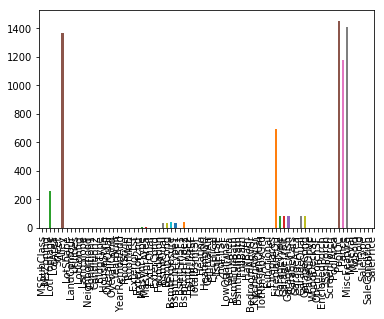

In [2]:
# Source & Data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
np.random.seed(10)
random.seed(10)

path = "D:/git/House_price_predictor/"
df = pd.read_csv(os.path.join(path, 'train.csv'))
Id = df.pop('Id') # Remove the Id column
print('Original df shape: ', df.shape)
print('Any NaN in target: ', df['SalePrice'].isnull().values.any()) # Check if the target column has NaN
# Count the number of NaN in each column
na_count = df.isnull().sum()
# Visualize the count of NaN
na_count.plot.bar()
# Drop the columns with more than one third of NaN numbers
na_msk = na_count < df.shape[0]/3
df = df.loc[:,na_msk]
print('df shape after dropping NaN columns: ', df.shape)

(1460, 75)


pandas.core.series.Series

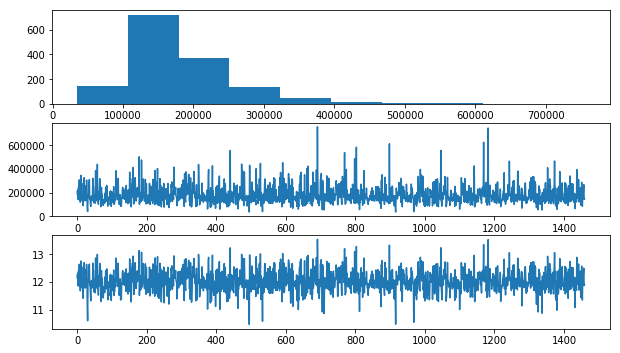

In [3]:
# Visualize the sale price
fig = plt.figure(figsize=(10,10))
num_rows = 5
ax1 = fig.add_subplot(num_rows,1,1)
ax2 = fig.add_subplot(num_rows,1,2)
ax3 = fig.add_subplot(num_rows,1,3)
print(df.shape)
log_price = np.log(df.SalePrice)

ax1.hist(df.SalePrice)
ax2.plot(df.SalePrice)
ax3.plot(log_price)

type(log_price)

In [4]:
### Find columns with non-digital element (object)
msk = df.dtypes == 'object'
colums_to_encode = df.loc[:,msk].columns.tolist()
# One hot encoding
df_encoded = pd.get_dummies(df, colums_to_encode)
print('df shape after one-hot encoding: ', df_encoded.shape)

df shape after one-hot encoding:  (1460, 271)


In [5]:
# Define X and y for the model input
y = df_encoded.pop('SalePrice').values
X = df_encoded.values
print('Shape of X: ', np.shape(X))
print('Shape of y: ', np.shape(y))

Shape of X:  (1460, 270)
Shape of y:  (1460,)


In [6]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# y_train_log = np.log(y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)
print('Train set size: ', X_train.shape)
print('Validation set size: ', X_val.shape)
print('Test set size: ', X_test.shape)

Train set size:  (876, 270)
Validation set size:  (292, 270)
Test set size:  (292, 270)


In [7]:
# Purify the data/ Handle NaN
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()
X_train = my_imputer.fit_transform(X_train)
X_val = my_imputer.transform(X_val)
X_test = my_imputer.transform(X_test)

In [8]:
import xgboost as xgb

def evalmape(preds,dmatrix):
    labels = dmatrix.get_label()
    error = sum(abs(preds-labels)*1.0/(labels))*1.0/len(labels)
    return ('mape', error)

In [64]:
def mapeobj(preds, labels):
    # Positive error: preds[i] >= labels[i]
    # Negative error: preds[i] < labels[i]
    # Loss funtion: J = 1/N * sum(sign(preds-labels)/lebel)
    beta = 5
    # Define a "bias mask" which gives larger weight for Negative errors (preds[i] < labels[i]).
    msk_bias = [1.0/beta if preds[i]-labels[i] >= 0 else beta for i in range(len(labels))]
    # 1st order gradient
#     grad = np.sign(preds-labels)*msk_bias*1.0/labels/len(labels)
#     hess = 0.01*np.ones(len(preds))
    grad = -10.0*(labels-preds)/labels
    hess = 10.0/labels
    return grad, hess


def mape(preds, labels):
    error = sum(abs(preds-labels)*1.0/(labels))*1.0/len(labels)
    return error

In [93]:
# Scikit-learn API
from xgboost import XGBRegressor
# Give larger weight to more recent data based on df.YrSold
sample_weights_data = 1 + (df.YrSold - 2010) * 0.2
my_model = XGBRegressor(n_estimators=1000, objective=mapeobj, random_state=10)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(X_train, y_train, 
             sample_weight=sample_weights_data, 
             early_stopping_rounds=5, 
             eval_set=[(X_val, y_val)],
             eval_metric=evalmape,
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None,
       objective=<function mapeobj at 0x000001D191885598>, random_state=10,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

<BarContainer object of 10 artists>

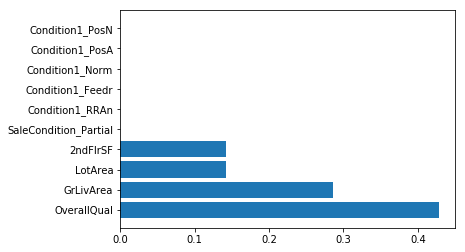

In [94]:
# Check the feature importances
features = df_encoded.columns.values.tolist()
importances = my_model.feature_importances_
feature_importances = pd.Series(importances, index = features)
feature_importances.sort_values(ascending=False, inplace=True)
# Plot the first 10 important features
plt.barh(feature_importances.index[:10], feature_importances[:10])

In [95]:
# make predictions
predictions = my_model.predict(X_test)

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error: ", mean_absolute_error(predictions, y_test))
print("Mean Absolute Percentage Error: ", mape(predictions, y_test))

Mean Absolute Error:  196702.406357
Mean Absolute Percentage Error:  1.10641263446


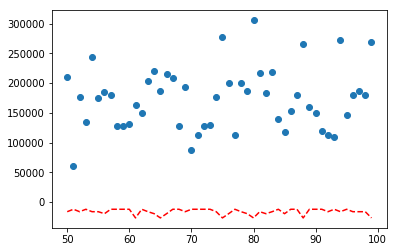

In [96]:
# Visualize the data and predictions
num_to_plot = 100
Id_test = np.arange(len(y_test))
plt.scatter(Id_test[50:num_to_plot], y_test[50:num_to_plot])
plt.plot(Id_test[50:num_to_plot], predictions[50:num_to_plot], c='r', ls='--')

In [97]:
# Generate house data which was sold in 2010
df_test = pd.DataFrame(X_test, columns=df_encoded.columns.values)
msk_2010 = df_test.YrSold == 2010
predictions_2010 = predictions[msk_2010]
y_test_2010 = y_test[msk_2010]
# Generate house data which was sold in 2006
msk_2006 = df_test.YrSold == 2006
predictions_2006 = predictions[msk_2006]
y_test_2006 = y_test[msk_2006]

Mean Absolute Percentage Error (2006):  1.10956445317


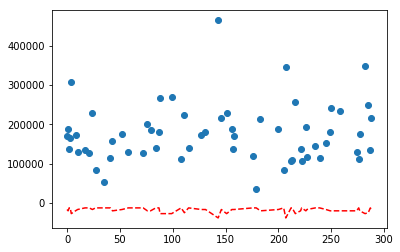

In [98]:
# Visualize house data and predictions for 2006
Id_2006 = Id_test[msk_2006]
plt.scatter(Id_2006, y_test_2006)
plt.plot(Id_2006, predictions_2006, c='r', ls='--')
print("Mean Absolute Percentage Error (2006): ", mape(predictions_2006, y_test_2006))

Mean Absolute Percentage Error (2010):  1.09917136413


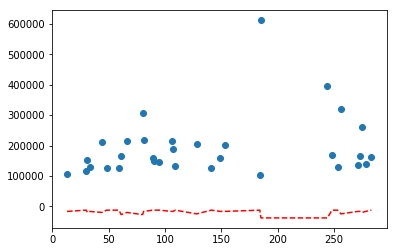

In [99]:
# Visualize house data and predictions for 2006
Id_2010 = Id_test[msk_2010]
plt.scatter(Id_2010, y_test_2010)
plt.plot(Id_2010, predictions_2010, c='r', ls='--')
print("Mean Absolute Percentage Error (2010): ", mape(predictions_2010, y_test_2010))

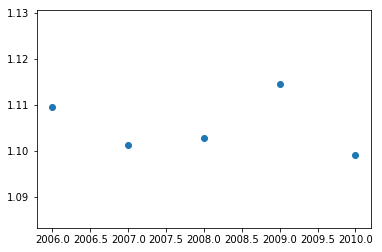

In [100]:
# Calculate mape for individual years
union_yr = list(set(df_test.YrSold.values))
union_yr.sort
mape_yr = []
for yr in union_yr:
    msk_yr = df_test.YrSold == yr
    mape_yr.append(mape(predictions[msk_yr], y_test[msk_yr]))

plt.scatter(union_yr, mape_yr)